In [1]:
from t_graph import TGraph, TEdge, TNode, WeightedGraphFactory
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import unicodedata as ud
# import pymc3 as pm

from measure import measure_performance, PerformanceMeasure


In [2]:
def create_log_grid(max_vertices, min_vertices, num_points_V, num_points_E):
    vertices = np.logspace(np.log10(min_vertices), np.log10(max_vertices), num_points_V, dtype=int)
    edges_completeness = np.linspace(start=0, stop=1, num=num_points_E, endpoint=True)

    assert len(edges_completeness) == num_points_E
    assert len(vertices) == num_points_V

    v_mesh, e_mesh = np.meshgrid(vertices, edges_completeness)
    e_mesh = np.round(e_mesh * v_mesh * (v_mesh - 1) / 2).astype(int)
    v_mesh = v_mesh.flatten()
    e_mesh = e_mesh.flatten()
        
    return v_mesh, e_mesh, edges_completeness


In [11]:
max_vertices = 3000
min_vertices = 10
num_points_v = 20
num_points_e = 20

vertices, edges, edges_completeness = create_log_grid(max_vertices, min_vertices, num_points_v, num_points_e)

In [12]:
@measure_performance
def measure_prims_performance(graph: TGraph, root_id: int) -> PerformanceMeasure:
    return graph.prims_mst(root_id)

@measure_performance
def measure_kruskal_performance(graph: TGraph, root_id) -> PerformanceMeasure:
    return graph.kruskal_mst(root_id)

def execute_experiments(graph: TGraph, measure_func: callable, num_experimets=10):
    n_vertices = graph.get_num_vertices()
    root_vertices = np.random.randint(0, n_vertices, num_experimets)
    results = [ measure_func(graph, root)[1].__dict__ for root, _ in zip(root_vertices, range(num_experimets)) ]
    
    return results

In [13]:
graph_factory = WeightedGraphFactory(vertices, edges, 100, 0)

In [47]:
# kruskal_data = []
# for g in tqdm(graph_factory):
#     kruskal_data.extend(execute_experiments(g, measure_kruskal_performance))
    
# kruskal_df = pd.DataFrame.from_records(kruskal_data)
# kruskal_df.to_csv('./outputs/kruskal.csv')

kruskal_df = pd.read_csv('./outputs/kruskal.csv')
kruskal_df.describe()

,input_V,input_E,elapsed_time,cpu_time,memory_usage,output_V,output_E,root_node
count,4000.000000,4.000000e+03,4000.000000,4000.000000,4.000000e+03,4000.000000,4000.000000,4000.000000
mean,576.500000,2.489576e+05,3759.533742,3761.164167,-7.779789e+05,576.500000,546.532500,283.279500
std,814.997426,6.581321e+05,10750.696024,10758.204413,5.446802e+06,814.997426,804.331484,478.064318
min,10.000000,0.000000e+00,0.124216,0.000000,-7.036928e+07,10.000000,0.000000,0.000000
25%,41.250000,1.830000e+02,1.416206,1.338500,0.000000e+00,41.250000,32.000000,14.000000
50%,175.000000,4.530000e+03,33.814311,33.569000,0.000000e+00,175.000000,148.000000,64.000000
75%,726.500000,1.075492e+05,1225.798726,1225.723750,0.000000e+00,726.500000,667.000000,332.000000
max,3000.000000,4.498500e+06,72436.816216,72504.108000,9.175040e+05,3000.000000,2999.000000,2990.000000


In [48]:
def calc_monomials(x):
    E = x["input_E"]
    V = x["input_V"]
    log_E = np.log10(E) if E > 0 else np.NaN
    log_V = np.log10(V) if V > 0 else np.NaN
    Elog_E = x["input_E"] * log_E
    Elog_V = x["input_E"] * log_V
    return pd.Series({
        "E": E,
        "V": V,
        "log_E": log_E,
        "log_V": log_V,
        "Elog_E": Elog_E,
        "Elog_V": Elog_V
    })

# Prepare the input and output data
X = kruskal_df[["input_E", "input_V"]].apply(calc_monomials, axis=1)
x = X.get("Elog_V").values.reshape(-1,1)

y = kruskal_df.cpu_time
# X = X.dropna()


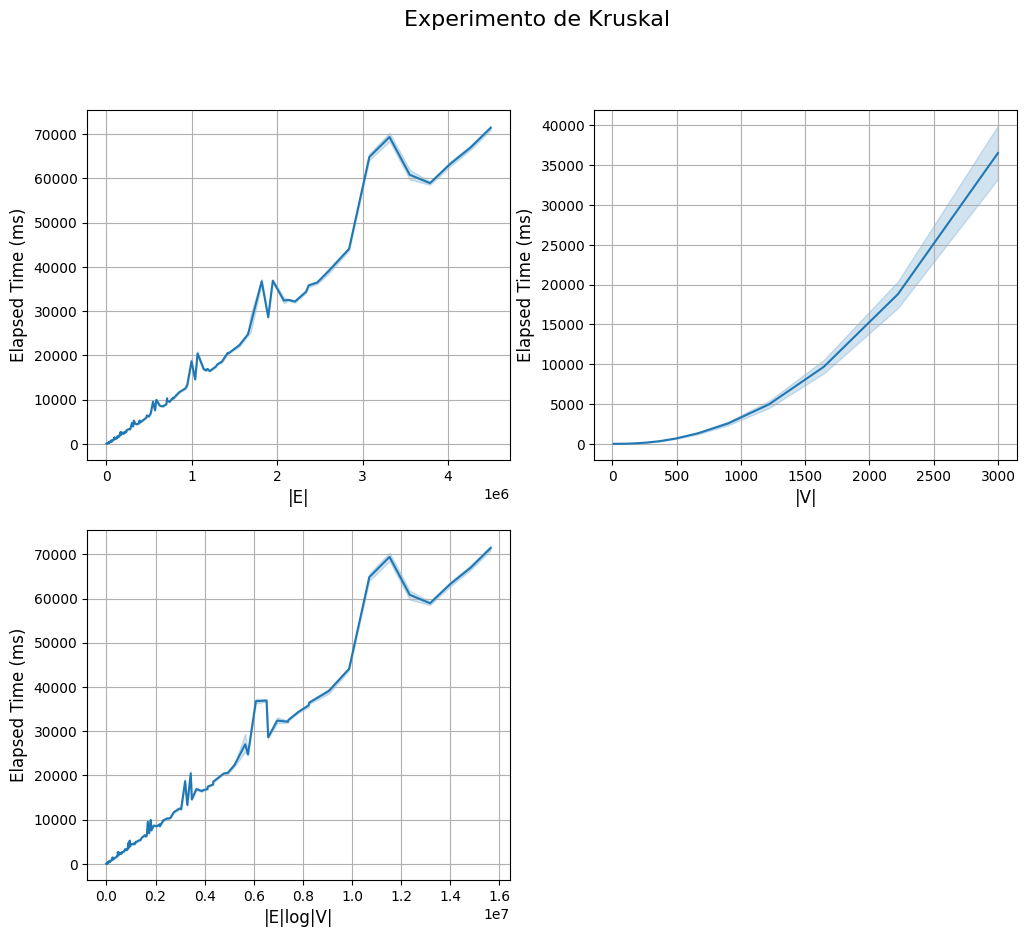

In [49]:
plt.figure(figsize=(12, 10))  # Set the figure size

plt.suptitle('Experimento de Kruskal', fontsize=16)  # Set the main title

plt.subplot(221)
sns.lineplot(data=kruskal_df, x='input_E', y='elapsed_time', markers=True, dashes=False)
plt.ylabel('Elapsed Time (ms)', fontsize=12)
plt.xlabel('|E|', fontsize=12)
plt.grid(True)

plt.subplot(222)
sns.lineplot(data=kruskal_df, x='input_V', y='elapsed_time', markers=True, dashes=False)
plt.ylabel('Elapsed Time (ms)', fontsize=12)
plt.xlabel('|V|', fontsize=12)
plt.grid(True)

plt.subplot(223)
sns.lineplot(x=X.get('Elog_V'), y=y, markers=True, dashes=False)
plt.ylabel('Elapsed Time (ms)', fontsize=12)
plt.xlabel('|E|log|V|', fontsize=12)
plt.grid(True)

# Show the grid lines for all subplots
plt.grid(True)

# Show the plot
plt.show()


In [70]:
y_high

array([  120364.92942188,   120364.92942188,   120364.92942188, ...,
       15641829.9643564 , 15641829.9643564 , 15641829.9643564 ])

In [65]:
low_dim_experiments = 10*num_points_e*10
x_high = x[low_dim_experiments:]
y_high = y[low_dim_experiments:]

# Create a linear regression model
model = LinearRegression()
# Fit the model to the data
model.fit(x_high, y_high)

# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_
R2 = model.score(x_high, y_high)

print(f"T(|E|, |V|) = {coefficients[0]:.5f} x |E|log|V|")
print(f"Coeficiente de deteriminação para os dados foi (R²) = {R2:.5f}")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

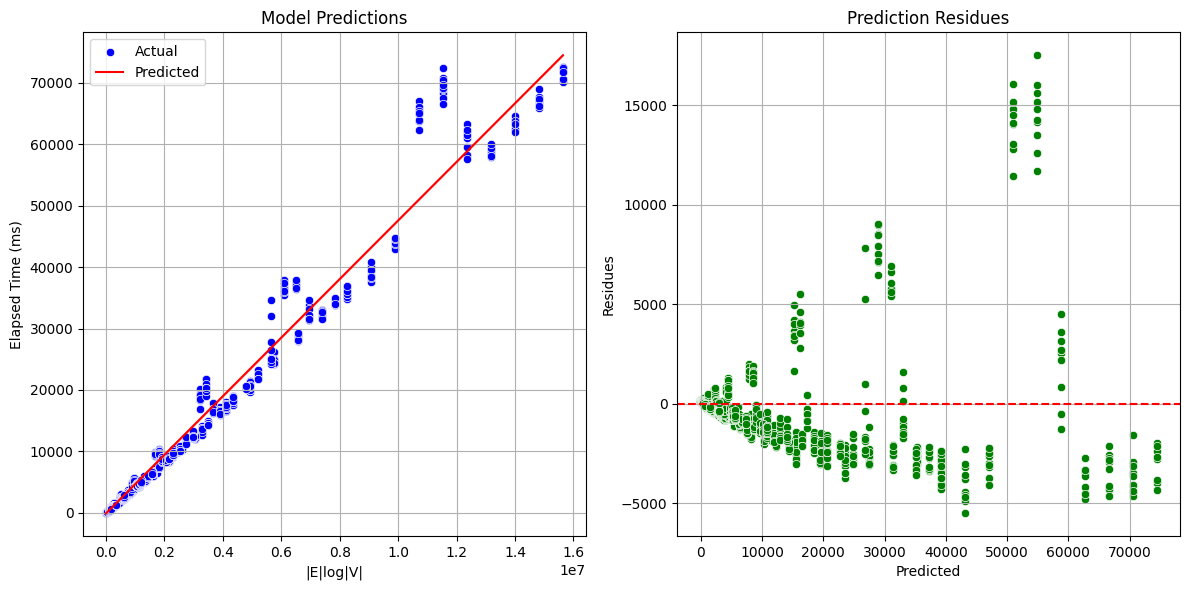

In [51]:
import seaborn as sns
# Generate model predictions
predictions = model.predict(x)

# Calculate prediction residues
residues = y - predictions


# Plot model predictions
plt.figure(figsize=(12, 6))

# Plot actual vs predicted values
plt.subplot(121)
sns.scatterplot(x=x.flatten(), y=y, color='blue', label='Actual')
sns.lineplot(x=x.flatten(), y=predictions, color='red', label='Predicted')
plt.xlabel('|E|log|V|')
plt.ylabel('Elapsed Time (ms)')
plt.title('Model Predictions')
plt.grid(True)
plt.legend()

# Plot prediction residues
plt.subplot(122)
sns.scatterplot(x=predictions, y=residues, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residues')
plt.grid(True)
plt.title('Prediction Residues')

# Show the plots
plt.tight_layout()
plt.show()